In [2]:
import cv2
import pywt
import numpy as np
import requests
import matplotlib.pyplot as plt
from io import BytesIO
import matplotlib.pyplot as plt
from PIL import Image

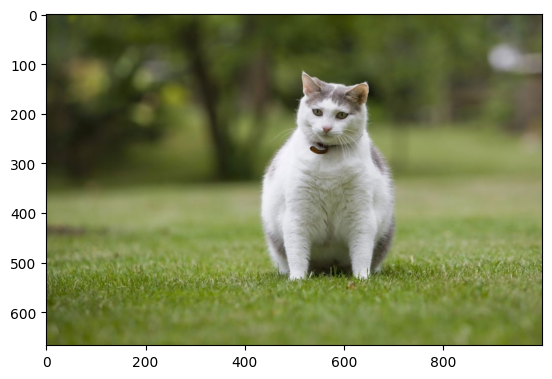

In [3]:
image_url = 'https://vetery.com.br/wp-content/uploads/2023/12/os-principais-riscos-da-obesidade-em-gatos.jpg'
response = requests.get(image_url, stream=True)

image = Image.open(BytesIO(response.content))
image_array = np.array(image)
plt.imshow(image_array)
plt.show()


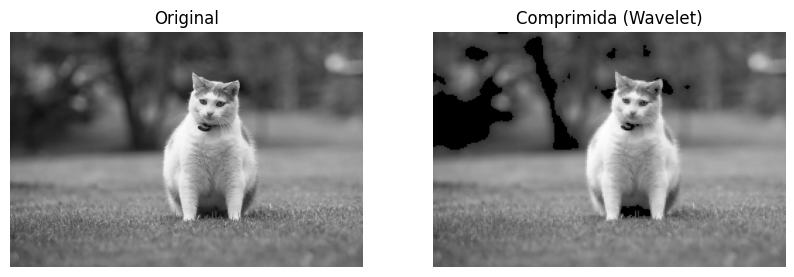

In [4]:
image_gray = image.convert("L")
image_array = np.array(image_gray, dtype=np.float32)

wavelet = 'haar'  # Otras opciones: 'db1', 'bior1.3', etc.
coeffs = pywt.wavedec2(image_array, wavelet, level=2)
coeffs_array, coeffs_slices = pywt.coeffs_to_array(coeffs)

threshold = 0.2 * np.max(coeffs_array)  # Se puede ajustar
coeffs_array[np.abs(coeffs_array) < threshold] = 0

coeffs_compressed = pywt.array_to_coeffs(coeffs_array, coeffs_slices, output_format='wavedec2')
image_compressed = pywt.waverec2(coeffs_compressed, wavelet)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(image_gray, cmap='gray')
axs[0].set_title("Original")
axs[0].axis("off")

axs[1].imshow(image_compressed, cmap='gray')
axs[1].set_title("Comprimida (Wavelet)")
axs[1].axis("off")

plt.show()

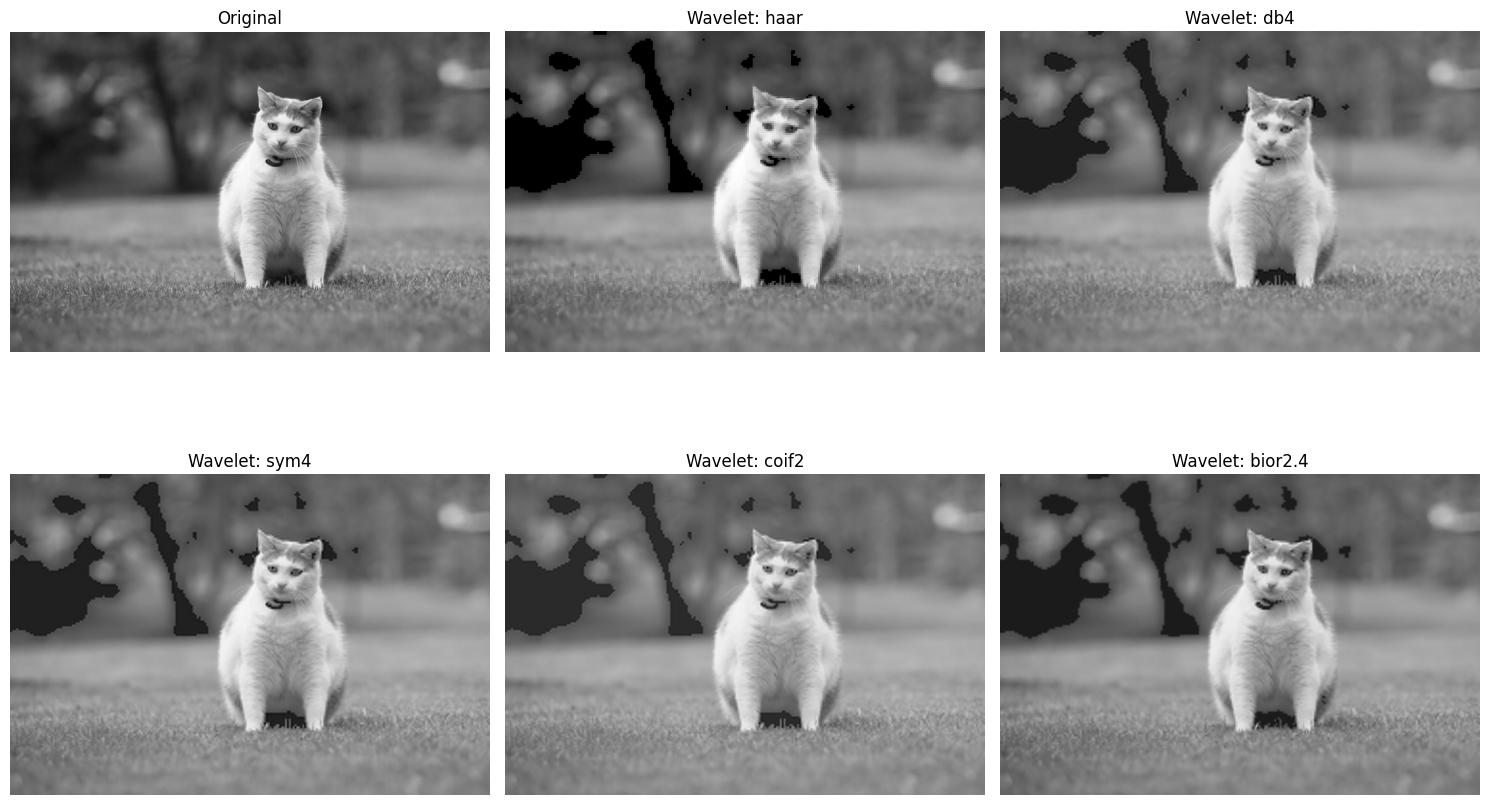

In [10]:
image_gray = image.convert("L")
image_array = np.array(image_gray, dtype=np.float32)

wavelets = ['haar', 'db4', 'sym4', 'coif2', 'bior2.4']
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.flatten()

axs[0].imshow(image_gray, cmap='gray')
axs[0].set_title("Original")
axs[0].axis("off")

for idx, wavelet in enumerate(wavelets, start=1):
    coeffs = pywt.wavedec2(image_array, wavelet, level=2)
    coeffs_array, coeffs_slices = pywt.coeffs_to_array(coeffs)
    
    threshold = 0.2 * np.max(coeffs_array)
    coeffs_array[np.abs(coeffs_array) < threshold] = 0
    
    coeffs_compressed = pywt.array_to_coeffs(coeffs_array, coeffs_slices, output_format='wavedec2')
    image_compressed = pywt.waverec2(coeffs_compressed, wavelet)
    
    axs[idx].imshow(image_compressed, cmap='gray')
    axs[idx].set_title(f"Wavelet: {wavelet}")
    axs[idx].axis("off")

plt.tight_layout()
plt.show()

In [11]:
def compress_wavelet(coeffs, threshold=20):
    coeffs_compressed = [coeffs[0]]
    for detail_level in coeffs[1:]:
        compressed_level = tuple(np.where(np.abs(d) > threshold, d, 0) for d in detail_level)
        coeffs_compressed.append(compressed_level)
    return coeffs_compressed

In [12]:
image_url   = 'https://vetery.com.br/wp-content/uploads/2023/12/os-principais-riscos-da-obesidade-em-gatos.jpg'
response    = requests.get(image_url)
img         = Image.open(BytesIO(response.content)).convert("RGB")
img_array   = np.array(img)
R, G, B     = img_array[:, :, 0], img_array[:, :, 1], img_array[:, :, 2]
wavelet     = 'haar'
level       = 3

In [13]:
def compress_channel(channel):
    coeffs = pywt.wavedec2(channel, wavelet, level=level)

    threshold = 0.2 * np.max(coeffs[0])
    coeffs_thresh = [coeffs[0]]

    for i in range(1, len(coeffs)):
        cH, cV, cD = coeffs[i]
        cH[np.abs(cH) < threshold] = 0
        cV[np.abs(cV) < threshold] = 0
        cD[np.abs(cD) < threshold] = 0
        coeffs_thresh.append((cH, cV, cD))

    compressed_channel = pywt.waverec2(coeffs_thresh, wavelet)
    return np.clip(compressed_channel, 0, 255).astype(np.uint8)


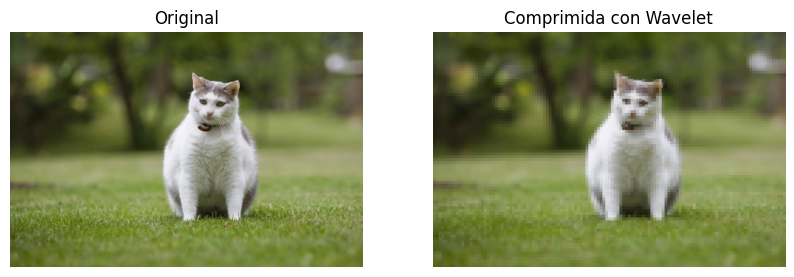

In [14]:
R_compressed = compress_channel(R)
G_compressed = compress_channel(G)
B_compressed = compress_channel(B)

compressed_img_array = np.stack([R_compressed, G_compressed, B_compressed], axis=2)
compressed_img = Image.fromarray(compressed_img_array)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(img)
axes[0].set_title("Original")
axes[0].axis("off")

axes[1].imshow(compressed_img)
axes[1].set_title("Comprimida con Wavelet")
axes[1].axis("off")

plt.show()

# Evaluación contínua
Compare el resultado de esta compresión utilizando otras funciones madre de wavelets (al menos 3), y adicionalmente busque cualquier otro algoritmo de compresión de imágenes y compare los resultados.

Para la comparación utilice PSNR y SSIM.

## **1. Peak Signal-to-Noise Ratio (PSNR)**
El **PSNR** mide la calidad de una imagen reconstruida comparándola con la imagen original. Se basa en el **error cuadrático medio (MSE)** y se expresa en decibeles (dB). Un valor mayor indica mejor calidad.

### **Fórmula:**
$$
PSNR = 10 \cdot \log_{10} \left(\frac{MAX_I^2}{MSE} \right)
$$

donde:
- $MAX_I$ es el valor máximo de un píxel (255 para imágenes en 8 bits).
- $MSE$ es el **error cuadrático medio**, dado por:
  $$
  MSE = \frac{1}{mn} \sum_{i=0}^{m-1} \sum_{j=0}^{n-1} (I(i,j) - I'(i,j))^2
  $$
  donde $I(i,j)$ es el valor del píxel en la imagen original y $I'(i,j)$ en la imagen reconstruida.

### **Interpretación:**
- **PSNR > 40 dB** → Calidad muy alta
- **30 - 40 dB** → Calidad aceptable
- **PSNR < 30 dB** → Pérdida de calidad visible

## **2. Structural Similarity Index (SSIM)**
El **SSIM** mide la similitud estructural entre dos imágenes considerando **luminancia, contraste y estructura**. Su valor varía entre -1 y 1, donde **1 significa imágenes idénticas**.

### **Fórmula:**
$$
SSIM(x, y) = \frac{(2\mu_x\mu_y + C_1)(2\sigma_{xy} + C_2)}{(\mu_x^2 + \mu_y^2 + C_1)(\sigma_x^2 + \sigma_y^2 + C_2)}
$$

donde:
- $\mu_x, \mu_y$ son las medias de las imágenes.
- $\sigma_x^2, \sigma_y^2$ son sus varianzas.
- $\sigma_{xy}$ es la covarianza.
- $C_1, C_2$ son constantes de estabilización.

### **Interpretación:**
- **SSIM ≈ 1** → Imágenes casi idénticas
- **0.8 - 0.99** → Buena calidad
- **SSIM < 0.8** → Diferencias perceptibles

## **3. Comparación entre PSNR y SSIM**
| Métrica | Tipo de Medida | Rango | Mejor Valor |
|---------|--------------|------|-------------|
| **PSNR** | Diferencia absoluta | 0 a ∞ | Mayor es mejor |
| **SSIM** | Similitud estructural | -1 a 1 | Más cercano a 1 |

PSNR es útil para evaluar la magnitud del error, pero **SSIM se correlaciona mejor con la percepción visual humana**.

Método                    | PSNR (dB)  | SSIM   | Tiempo (s)
Wavelet haar              | 25.12      | 0.5233 | 0.0025    
Wavelet db4               | 25.35      | 0.5458 | 0.0025    
Wavelet sym4              | 25.79      | 0.5555 | 0.0025    
Wavelet coif2             | 25.83      | 0.5561 | 0.0045    
JPEG Quality=30           | 38.16      | 0.9674 | 0.0010    
JPEG Quality=50           | 40.22      | 0.9796 | 0.0000    
JPEG Quality=70           | 42.23      | 0.9879 | 0.0005    
JPEG Quality=90           | 47.42      | 0.9957 | 0.0000    
SVD k=30                  | 35.14      | 0.9455 | 0.0596    
SVD k=50                  | 39.21      | 0.9743 | 0.0533    
SVD k=80                  | 44.48      | 0.9908 | 0.0561    


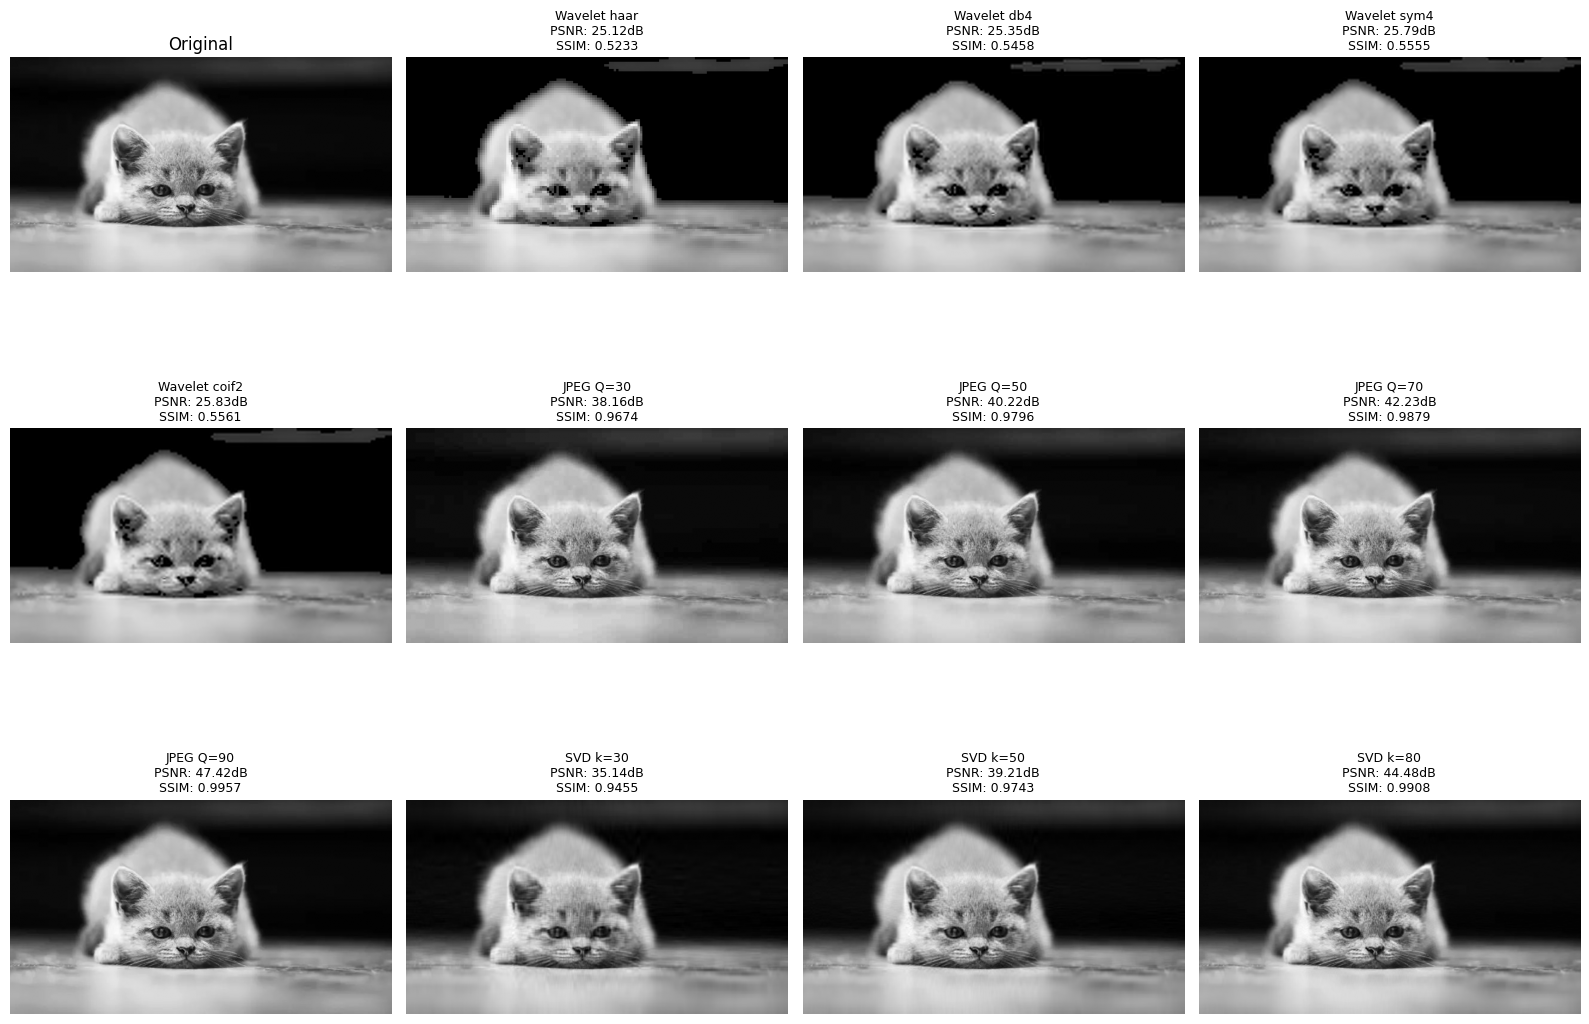


RANKING POR PSNR (Mayor es mejor):
1. JPEG Q=90                 - PSNR: 47.42dB, SSIM: 0.9957
2. SVD k=80                  - PSNR: 44.48dB, SSIM: 0.9908
3. JPEG Q=70                 - PSNR: 42.23dB, SSIM: 0.9879
4. JPEG Q=50                 - PSNR: 40.22dB, SSIM: 0.9796
5. SVD k=50                  - PSNR: 39.21dB, SSIM: 0.9743
6. JPEG Q=30                 - PSNR: 38.16dB, SSIM: 0.9674
7. SVD k=30                  - PSNR: 35.14dB, SSIM: 0.9455
8. Wavelet coif2             - PSNR: 25.83dB, SSIM: 0.5561
9. Wavelet sym4              - PSNR: 25.79dB, SSIM: 0.5555
10. Wavelet db4               - PSNR: 25.35dB, SSIM: 0.5458
11. Wavelet haar              - PSNR: 25.12dB, SSIM: 0.5233

RANKING POR SSIM (Mayor es mejor):
1. JPEG Q=90                 - SSIM: 0.9957, PSNR: 47.42dB
2. SVD k=80                  - SSIM: 0.9908, PSNR: 44.48dB
3. JPEG Q=70                 - SSIM: 0.9879, PSNR: 42.23dB
4. JPEG Q=50                 - SSIM: 0.9796, PSNR: 40.22dB
5. SVD k=50                  - SSIM: 0.97

In [18]:
import numpy as np
import pywt
import matplotlib.pyplot as plt
from PIL import Image
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import io
import time

def calculate_metrics(original, compressed):
    original = np.array(original, dtype=np.float32)
    compressed = np.array(compressed, dtype=np.float32)
    
    if compressed.shape != original.shape:
        compressed = compressed[:original.shape[0], :original.shape[1]]
    
    psnr = peak_signal_noise_ratio(original, compressed, data_range=255)
    ssim = structural_similarity(original, compressed, data_range=255)
    
    return psnr, ssim

def compress_wavelet(image_array, wavelet, threshold_factor=0.2):
    start_time = time.time()
    
    coeffs = pywt.wavedec2(image_array, wavelet, level=2)
    coeffs_array, coeffs_slices = pywt.coeffs_to_array(coeffs)
    
    threshold = threshold_factor * np.max(coeffs_array)
    coeffs_array[np.abs(coeffs_array) < threshold] = 0
    
    coeffs_compressed = pywt.array_to_coeffs(coeffs_array, coeffs_slices, output_format='wavedec2')
    image_compressed = pywt.waverec2(coeffs_compressed, wavelet)
    
    elapsed_time = time.time() - start_time
    
    return np.clip(image_compressed, 0, 255), elapsed_time

def compress_jpeg(image, quality):
    start_time = time.time()
    
    buffer = io.BytesIO()
    image.save(buffer, format='JPEG', quality=quality)
    buffer.seek(0)
    compressed_image = Image.open(buffer)
    
    elapsed_time = time.time() - start_time
    
    return compressed_image, elapsed_time

def compress_svd(image_array, k):
    start_time = time.time()
    
    U, S, Vt = np.linalg.svd(image_array, full_matrices=False)
    compressed = U[:, :k] @ np.diag(S[:k]) @ Vt[:k, :]
    
    elapsed_time = time.time() - start_time
    
    return np.clip(compressed, 0, 255), elapsed_time

image_url = 'https://ichef.bbci.co.uk/ace/ws/640/cpsprodpb/18504/production/_90488599_thinkstockphotos_gato6.jpg.webp'
response = requests.get(image_url, stream=True)

image = Image.open(BytesIO(response.content))
image_gray = image.convert("L")
image_array = np.array(image_gray, dtype=np.float32)

wavelets = ['haar', 'db4', 'sym4', 'coif2']
jpeg_qualities = [30, 50, 70, 90]
svd_k_values = [30, 50, 80]

results = []

print("="*70)
print(f"{'Método':<25} | {'PSNR (dB)':<10} | {'SSIM':<6} | {'Tiempo (s)':<10}")
print("="*70)

for wavelet in wavelets:
    compressed, exec_time = compress_wavelet(image_array, wavelet)
    psnr, ssim = calculate_metrics(image_array, compressed)
    results.append({
        'name': f'Wavelet {wavelet}',
        'image': compressed,
        'psnr': psnr,
        'ssim': ssim,
        'time': exec_time
    })
    print(f"{'Wavelet ' + wavelet:<25} | {psnr:<10.2f} | {ssim:<6.4f} | {exec_time:<10.4f}")

for quality in jpeg_qualities:
    compressed_pil, exec_time = compress_jpeg(image_gray, quality)
    compressed_array = np.array(compressed_pil, dtype=np.float32)
    psnr, ssim = calculate_metrics(image_array, compressed_array)
    results.append({
        'name': f'JPEG Q={quality}',
        'image': compressed_array,
        'psnr': psnr,
        'ssim': ssim,
        'time': exec_time
    })
    print(f"{'JPEG Quality=' + str(quality):<25} | {psnr:<10.2f} | {ssim:<6.4f} | {exec_time:<10.4f}")

for k in svd_k_values:
    compressed, exec_time = compress_svd(image_array, k)
    psnr, ssim = calculate_metrics(image_array, compressed)
    results.append({
        'name': f'SVD k={k}',
        'image': compressed,
        'psnr': psnr,
        'ssim': ssim,
        'time': exec_time
    })
    print(f"{'SVD k=' + str(k):<25} | {psnr:<10.2f} | {ssim:<6.4f} | {exec_time:<10.4f}")

print("="*70)

num_results = len(results)
cols = 4
rows = (num_results + cols) // cols

fig, axs = plt.subplots(rows, cols, figsize=(16, rows*4))
axs = axs.flatten()

axs[0].imshow(image_gray, cmap='gray')
axs[0].set_title("Original")
axs[0].axis("off")

for idx, result in enumerate(results, start=1):
    axs[idx].imshow(result['image'], cmap='gray')
    title = f"{result['name']}\nPSNR: {result['psnr']:.2f}dB\nSSIM: {result['ssim']:.4f}"
    axs[idx].set_title(title, fontsize=9)
    axs[idx].axis("off")

for idx in range(num_results + 1, len(axs)):
    axs[idx].axis("off")

plt.tight_layout()
plt.savefig('comparacion_compresion.png', dpi=150, bbox_inches='tight')
plt.show()

results_sorted = sorted(results, key=lambda x: x['psnr'], reverse=True)

print("\n" + "="*70)
print("RANKING POR PSNR (Mayor es mejor):")
print("="*70)
for i, result in enumerate(results_sorted, 1):
    print(f"{i}. {result['name']:<25} - PSNR: {result['psnr']:.2f}dB, SSIM: {result['ssim']:.4f}")

results_sorted_ssim = sorted(results, key=lambda x: x['ssim'], reverse=True)

print("\n" + "="*70)
print("RANKING POR SSIM (Mayor es mejor):")
print("="*70)
for i, result in enumerate(results_sorted_ssim, 1):
    print(f"{i}. {result['name']:<25} - SSIM: {result['ssim']:.4f}, PSNR: {result['psnr']:.2f}dB")